# Kaggle - Toxic Comment Classification Challenge
# David Modjeska

In [1]:
import datetime
import numpy as np
import pandas as pd
import re
import seaborn as sns

from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, auc, f1_score, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC as SVC
from lightgbm import LGBMClassifier as LGBMC

import tensorflow as tf
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.estimator import model_to_estimator

import pydot
import pydotplus
import graphviz

In [2]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = int(multiprocessing.cpu_count() / 2)

In [3]:
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_colwidth', 200)

### Tools for Multiprocessing

In [102]:
def parallel_function_wrapper(my_function, parms_tuple):
        
    # call the given function according to the correct number of parameters
    if (parms_tuple[2] is not None) & (parms_tuple[3] is not None):
        result = my_function(parms_tuple[1], parms_tuple[2], parms_tuple[3]) 
    elif parms_tuple[2] is not None:
        result = my_function(parms_tuple[1], parms_tuple[2]) 
    else: 
        result = my_function(parms_tuple[1])     

    # return the input ID with the return values
    return_tuple = (parms_tuple[0], result)    
    return(return_tuple)

In [134]:
def parallelize_function(data, my_function, value_field, parameter_2 = None, parameter_3 = None):
    
    # prepare parameters for parallelized function call (including the row names for later sorting)
    data_list_with_row_names = list(data.apply(lambda x: (x.name, x[value_field], parameter_2, parameter_3),
                                               axis = 1))

    # prepare the progress bar
    inputs = tqdm(data_list_with_row_names)

    # execute the given function using multiprocessing
    if __name__ == "__main__":
        result = Parallel(n_jobs = num_cores)(delayed(parallel_function_wrapper)(my_function, value) for value in inputs)
    
    # sort the results using row names
    result_df = pd.DataFrame(result, columns = ('row_name', 'value'))
    result_df['row_name'] = result_df['row_name'].astype(int)
    result_df = result_df.sort_values(by = 'row_name') 
    
    return(result_df['value'].values)

## Load and Clean the Data

### Load the Data

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [8]:
train.shape

(159571, 8)

In [9]:
test.shape

(153164, 2)

In [10]:
test_labels.shape

(153164, 7)

In [11]:
train.isnull().sum().sum()

0

In [12]:
test.isnull().sum().sum()

0

In [13]:
test_labels.isnull().sum().sum()

0

In [14]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [15]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

num_labels = len(label_columns)

In [16]:
scored_y_test_indices = test_labels['toxic'].apply(lambda x: x != -1)

test = test[scored_y_test_indices].reset_index(drop = True)
test_labels = test_labels[scored_y_test_indices].reset_index(drop = True)

print(test.shape)
print(test_labels.shape)

(63978, 2)
(63978, 7)


In [17]:
train = train.drop('id', axis = 1).reset_index(drop = True)
test = test.drop('id', axis = 1).reset_index(drop = True)

### Profanity

In [18]:
import profanity_check

def my_profanity_check(string):
    return(profanity_check.predict_prob([string])[0])
    
train_profanity_list = parallelize_function(train, my_profanity_check, 'comment_text', None, None)
test_profanity_list = parallelize_function(test, my_profanity_check, 'comment_text', None, None)

  0%|          | 0/159571 [00:00<?, ?it/s]

my_profanity_check


  0%|          | 0/63978 [00:00<?, ?it/s]

my_profanity_check


In [19]:
train['profanity'] = train_profanity_list
test['profanity'] = test_profanity_list

## Text Features

In [20]:
text_feature_columns = [
    'num_character', 'num_word', 'num_number',
    'num_uppercase', 'num_asterisk', 'num_bang', 'num_question',
    'reading_ease', 'grade_level',
    'negative_sentiment']

In [21]:
text_feature_columns += ['profanity']

In [22]:
import textstat
from nltk.sentiment import SentimentIntensityAnalyzer

In [23]:
# TO DO: num stop words
def add_text_features(comments):

    #----- language
    
#     comments['detect_language'] = parallelize_function(comments, my_detect, 'comment_text', None, None)
#     comments['is_skip'] = comments['detect_language'].isin(skip_languages)
#     comments['is_english'] = comments['detect_language'].apply(lambda x: x == 'en')
    
    #-----
    
    # number of characters
    comments['num_character'] = comments['comment_text'].str.len()

    # number of words
    comments['num_word'] = comments['comment_text'].str.split().str.len()
    
    # number of upper-case letters 
    comments['num_uppercase'] = comments['comment_text'].str.findall(r'[A-Z]').str.len()     

    # number of asterisks
    comments['num_asterisk'] = comments['comment_text'].str.findall(r'[*]').str.len()
    
    # number of exclamation marks
    comments['num_bang'] = comments['comment_text'].str.findall(r'[!]').str.len()
    
    # number of question marks
    comments['num_question'] = comments['comment_text'].str.findall(r'[?]').str.len()  
    
    # number of numbers
    comments['num_number'] = comments['comment_text'].str.findall(r'[0-9]').str.len()  
    
    #----- text analysis
    
    # reading ease
    comments['reading_ease'] = parallelize_function(comments, textstat.flesch_reading_ease, 'comment_text', None, None)
    comments['reading_ease'] = comments['reading_ease'].astype(float)
    
    # grade level    
    comments['grade_level'] = parallelize_function(comments, textstat.flesch_kincaid_grade, 'comment_text', None, None)
    comments['grade_level'] = comments['grade_level'].astype(float)
    
    #----- sentiment analysis
    
    sia = SentimentIntensityAnalyzer()

    my_lambda = lambda x: sia.polarity_scores(x)['neg']
    comments['negative_sentiment'] = parallelize_function(comments, my_lambda, 'comment_text', None, None)
    comments['negative_sentiment'] = comments['negative_sentiment'].astype(float)
    
    return(comments)

In [24]:
train = add_text_features(train)
test = add_text_features(test)

  0%|          | 0/159571 [00:00<?, ?it/s]

flesch_reading_ease


  0%|          | 0/159571 [00:00<?, ?it/s]

flesch_kincaid_grade


  0%|          | 0/159571 [00:00<?, ?it/s]

<lambda>


  0%|          | 0/63978 [00:00<?, ?it/s]

flesch_reading_ease


  0%|          | 0/63978 [00:00<?, ?it/s]

flesch_kincaid_grade


  0%|          | 0/63978 [00:00<?, ?it/s]

<lambda>


### Clean the Comments

In [25]:
def clean_comment(text, the_stopwords, remove_stopwords = True):
    
    output = ''
    
    comment = str(text).replace("\n", " ")
    comment = re.sub(r'[^\w]', ' ', comment).lower()
    comment = re.sub(r'[\s]+',' ', comment)
        
    if remove_stopwords:
        comment = comment.split(" ")
        for word in comment:
            if word not in the_stopwords:
                output += " " + word
    else:
        output = comment
        
    output = output.strip()
    return(output)

In [26]:
the_stopwords = stopwords.words('English')

In [27]:
train['comment_text_clean'] = parallelize_function(train, clean_comment, 'comment_text', the_stopwords, False)

  0%|          | 0/159571 [00:00<?, ?it/s]

clean_comment


In [28]:
test['comment_text_clean'] = parallelize_function(test, clean_comment, 'comment_text', the_stopwords, False)

  0%|          | 0/63978 [00:00<?, ?it/s]

clean_comment


In [29]:
# convert label values to numeric
train[label_columns] = train[label_columns].applymap(lambda x: pd.to_numeric(x))
test_labels[label_columns] = test_labels[label_columns].applymap(lambda x: pd.to_numeric(x))

In [30]:
train[text_feature_columns] = train[text_feature_columns].applymap(lambda x: pd.to_numeric(x))
test[text_feature_columns] = test[text_feature_columns].applymap(lambda x: pd.to_numeric(x))

In [31]:
X_train = train['comment_text_clean']
X_test = test['comment_text_clean']

In [32]:
X_train_char = train[text_feature_columns]
X_test_char = test[text_feature_columns]

In [33]:
my_scaler = StandardScaler()
my_scaler.fit(X_train_char)

X_train_char = my_scaler.transform(X_train_char)
X_test_char = my_scaler.transform(X_test_char)

In [34]:
y_train = train[label_columns].values
y_test = test_labels[label_columns].values

### Vectorize the Text

#### Define helper functions to get top features names

In [35]:
# from https://buhrmann.github.io/tfidf-analysis.html

def top_tfidf_features(row, features, top_n = 25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_features_in_doc(Xtr, features, row_id, top_n = 25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_features(row, features, top_n)

#### Vectorize Comments

In [36]:
vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 0.0001, stop_words = 'english',
                                 use_idf = True, ngram_range = (1, 1), max_features = 10000)
vectorizer.fit(train['comment_text'])

X_train_tfidf = vectorizer.transform(train['comment_text'])
X_test_tfidf = vectorizer.transform(test['comment_text'])

In [37]:
X_train_all = X_train_tfidf
X_test_all = X_test_tfidf

In [38]:
y_train = train[label_columns]
y_test = test_labels[label_columns]

In [39]:
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 25
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['mitt', 'barbaro', 'foreskin', 'chand', 'dungeons', 'garrison', 'bauder', 'noes', 'orangemike', 'knob', 'tipler', 'truman', 'uruguay', 'cody', 'belle', 'jws', 'billcj', 'bail', 'wtc', 'yadavs', 'rexcurry', 'féin', '420', 'salvio', 'hazel']


In [40]:
len(features)

10000

## Plotting Functions 

In [41]:
def display_roc_curve(y_true, y_predict, label, ax):

    fp_rate, tp_rate, _ = roc_curve(y_true, y_predict)
    roc_auc = auc(fp_rate, tp_rate)


    ax.set_title('label = ' + label)

    ax.plot(fp_rate, tp_rate, 'b', label='AUC = %0.2f'% roc_auc)
    ax.legend(loc = 'lower right')

    ax.plot([0,1],[0,1], 'r--', lw = 1)
    ax.set_xlim([-0.1, 1.2])
    ax.set_ylim([-0.1, 1.2])

    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

In [42]:
def plot_roc_auc_grid(y_test, all_predictions):
    fig, axes = plt.subplots(3, 2, figsize = (10, 14))
    fig.suptitle('ROC AUC by Label\n', fontsize = 14)

    for i in range(num_labels):
        
        # if these predictions have two columns, use the second column
        this_all_predictions = all_predictions[i]
        if np.ndim(this_all_predictions) == 2:
            this_all_predictions = this_all_predictions[:, 1]
            
        ax = axes[i // 2, i % 2]
        display_roc_curve(y_test.iloc[:, i], this_all_predictions, label_columns[i], ax)

    plt.tight_layout()
    plt.show()    

## Baseline Model

In [43]:
baseline_predictions = np.zeros(y_test.shape)

In [44]:
all_scores_baseline = pd.DataFrame()

for i in range(num_labels):
    this_predict_proba = baseline_predictions[:, i] 
    
    this_roc_auc_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'accuracy' : [round(accuracy_score(y_test.iloc[:, i], this_predict_proba), 4)],
        'F1' : [round(f1_score(y_test.iloc[:, i], this_predict_proba), 4)],
        'ROC AUC' : [round(roc_auc_score(y_test.iloc[:, i], this_predict_proba), 4)]
    })
    all_scores_baseline = pd.concat([all_scores_baseline, this_roc_auc_score], axis = 0)

In [45]:
all_scores_baseline.reset_index(drop = True)

,column,accuracy,F1,ROC AUC
0,toxic,0.9048,0.0,0.5
1,severe_toxic,0.9943,0.0,0.5
2,obscene,0.9423,0.0,0.5
3,threat,0.9967,0.0,0.5
4,insult,0.9464,0.0,0.5
5,identity_hate,0.9889,0.0,0.5


In [46]:
print('Mean accuracy: ' + str(round(all_scores_baseline['accuracy'].mean(), 4)))
print('Mean F1: ' + str(round(all_scores_baseline['F1'].mean(), 4)))
print('Mean ROC AUC: ' + str(round(all_scores_baseline['ROC AUC'].mean(), 4)))

Mean accuracy: 0.9622
Mean F1: 0.0
Mean ROC AUC: 0.5


## Classic Machine Learning - Ensemble - Vectorized Text

### Create the Component Models

In [47]:
xgbc = LGBMC(boosting_type = 'gbdt',
             objective = 'binary',
             eval_metric = 'logloss',
           use_label_encoder = False,
           n_estimators = 150, 
           max_depth = 7,
           learning_rate = 0.35,
           n_jobs = num_cores)

In [48]:
log_reg = LogReg(C = 1,
                n_jobs = num_cores)

In [49]:
rfc = LGBMC(boosting_type = 'rf',
            objective = 'binary',
            n_estimators = 300,
            max_depth = None,
            n_jobs = num_cores,
            feature_fraction = 0.9,
            bagging_fraction = 0.8,
            bagging_freq = 5)

### Cross-validate the ensemble

In [50]:
all_ensembles = [None] * num_labels
print('TRAIN')
    
for i in range(num_labels):
    print('Label ' + str(i))
    this_ensemble = VotingClassifier(estimators = [
        ('xgbc', xgbc), 
        ('log_reg', log_reg), 
        ('rfc', rfc)
    ],
                                     voting = 'soft',
                                     n_jobs = num_cores)
    this_ensemble.fit(X_train_all, y_train.iloc[:, i])
    all_ensembles[i] = this_ensemble

TRAIN
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [51]:
classic_ml_start_time = datetime.datetime.now()
print("Classic machine learning - start time: ", classic_ml_start_time)

Classic machine learning - start time:  2021-07-18 18:03:12.148447


In [52]:
all_cv_results = pd.DataFrame()
print('CV')

for i in range(num_labels):
    print('Label ' + str(i))
    
    these_cv_scores = cross_val_score(estimator = all_ensembles[i], 
                                     X = X_train_all, 
                                     y = y_train.iloc[:, i],
                                     cv = 3,
                                     n_jobs = num_cores,
                                     scoring = 'roc_auc',
                                     verbose = 1)    
    these_cv_scores_mean = round(these_cv_scores.mean(), 4)
    print('     ROC AUC: ' + str(these_cv_scores_mean))

    this_cv_result = pd.DataFrame({ 'Label' : [label_columns[i]], 'ROC AUC' : [these_cv_scores_mean] })        
    all_cv_results = pd.concat([all_cv_results, this_cv_result], axis = 0)

CV
Label 0


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  2.8min finished


     ROC AUC: 0.9659
Label 1


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  2.2min finished


     ROC AUC: 0.9818
Label 2


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  2.6min finished


     ROC AUC: 0.9841
Label 3


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  2.1min finished


     ROC AUC: 0.9785
Label 4


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  2.7min finished


     ROC AUC: 0.9734
Label 5


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  2.3min finished


     ROC AUC: 0.9679


In [53]:
classic_ml_end_time = datetime.datetime.now()
print("Classic machine learning - end time: ", classic_ml_end_time)
print("Classic machine learning elapsed time: ", classic_ml_end_time - classic_ml_start_time)

Classic machine learning - end time:  2021-07-18 18:17:53.075829
Classic machine learning elapsed time:  0:14:40.927382


In [54]:
all_cv_results

,Label,ROC AUC
0,toxic,0.9659
0,severe_toxic,0.9818
0,obscene,0.9841
0,threat,0.9785
0,insult,0.9734
0,identity_hate,0.9679


In [55]:
print(round(all_cv_results['ROC AUC'].mean(), 4))

0.9753


### Generate the Test Predictions

In [56]:
all_predictions_ml = [None] * num_labels
all_roc_auc_scores_ml = pd.DataFrame()

print('PREDICT')

for i in range(num_labels):
    print('Label ' + str(i))
    
    this_predict_proba = all_ensembles[i].predict_proba(X_test_all)
    all_predictions_ml[i] = this_predict_proba
    
    this_roc_auc_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test.iloc[:, i], this_predict_proba[:, 1]), 4)]
    })
    all_roc_auc_scores_ml = pd.concat([all_roc_auc_scores_ml, this_roc_auc_score], axis = 0)

PREDICT
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [57]:
all_roc_auc_scores_ml.reset_index(drop = True)

,column,ROC AUC
0,toxic,0.9557
1,severe_toxic,0.9784
2,obscene,0.9702
3,threat,0.9809
4,insult,0.9624
5,identity_hate,0.9736


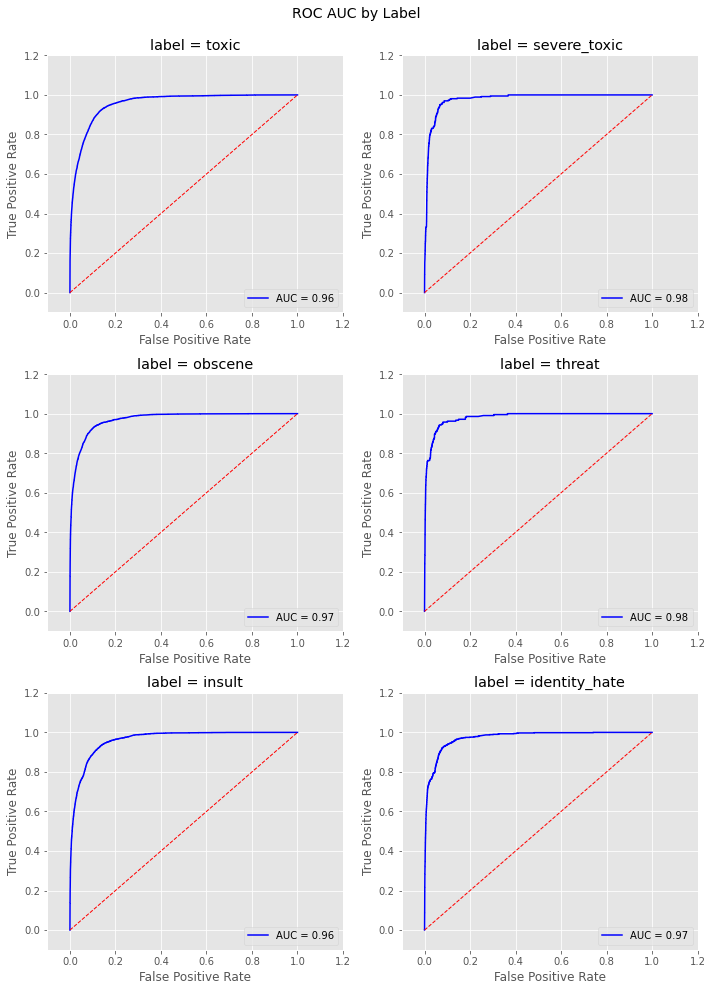

In [58]:
plot_roc_auc_grid(y_test, all_predictions_ml)

In [59]:
print(round(all_roc_auc_scores_ml['ROC AUC'].mean(), 4))

0.9702


## Deep Learning - LSTM - Embedded Text

*Adapted from https://towardsdatascience.com/classify-toxic-online-comments-with-lstm-and-glove-e455a58da9c7*

### Preparation

In [60]:
X_train_list = parallelize_function(train, clean_comment, 'comment_text', the_stopwords, True)

  0%|          | 0/159571 [00:00<?, ?it/s]

clean_comment


In [61]:
X_test_list = parallelize_function(test, clean_comment, 'comment_text', the_stopwords, True)

  0%|          | 0/63978 [00:00<?, ?it/s]

clean_comment


In [62]:
MAX_NB_WORDS = 10000    # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe) 

In [63]:
def prepare_data_for_learning(X_list, y, tokenizer = None):
    
    if tokenizer is None:
        tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
        tokenizer.fit_on_texts(X_list)
    
    sequences = tokenizer.texts_to_sequences(X_list)
    word_index = tokenizer.word_index
    
    print('Vocabulary size:', len(word_index))
    print('')

    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', y.shape)
    
    return(sequences, word_index, data, tokenizer)

In [64]:
sequences, word_index, prepared_data_train, tokenizer = prepare_data_for_learning(X_train_list, y_train)

Vocabulary size: 186486

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [65]:
indices = np.arange(prepared_data_train.shape[0])
np.random.shuffle(indices)

data = prepared_data_train[indices]
labels = y_train.iloc[indices, :]

In [66]:
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train_dl = data[: -num_validation_samples]
y_train_dl = labels[: -num_validation_samples]

X_val_dl = data[-num_validation_samples: ]
y_val_dl = labels[-num_validation_samples: ]

In [67]:
print('Number of entries in each category:')
print('training: ', y_train_dl.sum(axis = 0))
print('validation: ', y_val_dl.sum(axis = 0))

Number of entries in each category:
training:  toxic            12243
severe_toxic      1262
obscene           6751
threat             385
insult            6307
identity_hate     1128
dtype: int64
validation:  toxic            3051
severe_toxic      333
obscene          1698
threat             93
insult           1570
identity_hate     277
dtype: int64


#### Data Sample

In [68]:
sample_record_number = 11

print('Tokenized sentences: \n', data[sample_record_number])
print('')
print('One hot label: \n', labels.iloc[sample_record_number, :])

Tokenized sentences: 
 [ 20  12  85   4 341   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]

One hot label: 
 toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 91445, dtype: int64


In [69]:
GLOVE_DIR = "C:/Users/dmodj/Desktop/Dev/Tools/GloVe/glove.6B/glove.6B." + str(EMBEDDING_DIM) + "d.txt"

In [70]:
embeddings_index = {}
file = open(GLOVE_DIR, encoding = 'utf-8')

print('Loading GloVe from:', GLOVE_DIR,'...', end = '')
for line in file:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype = 'float32')
file.close()
print("Done.\n Proceeding with Embedding Matrix...", end = "")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print(" Completed")

Loading GloVe from: C:/Users/dmodj/Desktop/Dev/Tools/GloVe/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed


### Learning

In [71]:
sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = 'int32')

embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable = False,
                           name = 'embeddings')

embedded_sequences = embedding_layer(sequence_input)

In [72]:
#x = LSTM(units = 60, return_sequences = True, name = 'lstm_layer')(embedded_sequences)
x = Bidirectional(LSTM(units = 60, return_sequences = True, name = 'lstm_layer'))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)

preds = Dense(units = num_labels, activation = "sigmoid")(x)

In [73]:
model = Model(sequence_input, preds)

model.compile(loss = 'binary_crossentropy',
             optimizer ='adam',
             metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          18648700  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 120)          77280     
_________________________________________________________________
global_max_pooling1d (Global (None, 120)               0         
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [74]:
tf.keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [75]:
print('Training progress:')

Training progress:


In [76]:
dl_start_time = datetime.datetime.now()
print("Deep learning - start time: ", dl_start_time)

Deep learning - start time:  2021-07-18 18:18:21.534081


In [77]:
history = model.fit(X_train_dl, y_train_dl, epochs = 2, batch_size = 32, validation_data = (X_val_dl, y_val_dl))

Epoch 1/2
3990/3990 [==============================] - 92s 22ms/step - loss: 0.0633 - accuracy: 0.9118 - val_loss: 0.0512 - val_accuracy: 0.9943
Epoch 2/2
3990/3990 [==============================] - 86s 22ms/step - loss: 0.0503 - accuracy: 0.9848 - val_loss: 0.0490 - val_accuracy: 0.9943


In [78]:
dl_end_time = datetime.datetime.now()
print("Deep learning - end time: ", dl_end_time)
print("Deep learning - elapsed time: ", dl_end_time - dl_start_time)

Deep learning - end time:  2021-07-18 18:21:19.437454
Deep learning - elapsed time:  0:02:57.903373


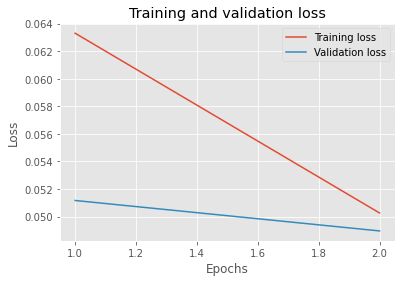

In [79]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show();

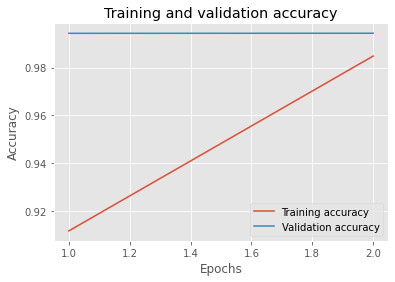

In [80]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show();

In [81]:
# serialize model to JSON

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")

print("Saved model to disk")

Saved model to disk


### Prediction

In [82]:
# load JSON and create model

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")

Loaded model from disk


In [83]:
sequences_test, word_index_test, prepared_data_test, _ = prepare_data_for_learning(X_test_list, y_test, tokenizer)

Vocabulary size: 186486

Shape of data tensor: (63978, 200)
Shape of label tensor: (63978, 6)


In [84]:
x_test_dl = prepared_data_test

In [85]:
predict_prob_test_dl = loaded_model.predict(x_test_dl) 

In [86]:
all_scores_dl = pd.DataFrame()

for i in range(num_labels):
    this_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test.iloc[:, i], predict_prob_test_dl[:, i]), 4)]
    })
    
    all_scores_dl = pd.concat([all_scores_dl, this_score], axis = 0)

all_scores_dl.reset_index(drop = True, inplace = True)

In [87]:
all_predictions_dl = [None] * num_labels
all_roc_auc_scores_dl = pd.DataFrame()

print('PREDICT')

for i in range(num_labels):
    print('Label ' + str(i))
    
    this_predict_proba = predict_prob_test_dl[:, i]
    all_predictions_dl[i] = this_predict_proba
    
    this_roc_auc_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test.iloc[:, i], this_predict_proba), 4)]
    })
    all_roc_auc_scores_dl = pd.concat([all_roc_auc_scores_dl, this_roc_auc_score], axis = 0)

PREDICT
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [88]:
all_roc_auc_scores_dl.reset_index(drop = True)

,column,ROC AUC
0,toxic,0.9595
1,severe_toxic,0.9885
2,obscene,0.9732
3,threat,0.9839
4,insult,0.9661
5,identity_hate,0.9759


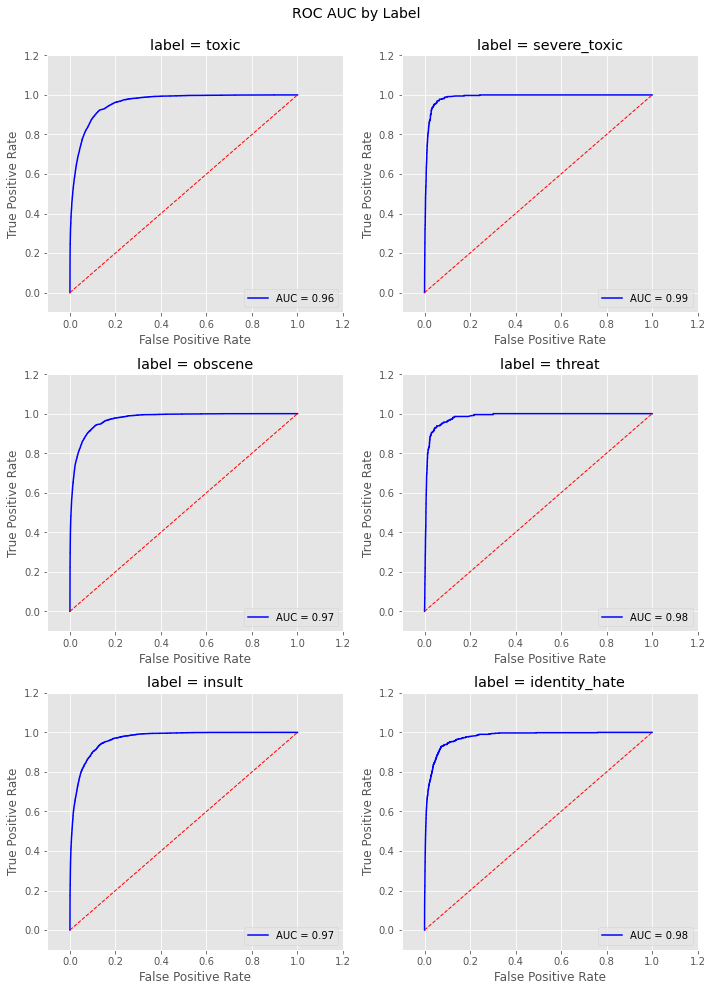

In [89]:
plot_roc_auc_grid(y_test, all_predictions_dl)

In [90]:
print(round(all_scores_dl['ROC AUC'].mean(), 4))

0.9745


## Classic Machine Learning - Ensemble - Text Statistics

### Create the Component Models

In [152]:
xgbc_textstat = LGBMC(
        boosting_type = 'gbdt',
        objective = 'binary',
        eval_metric = 'logloss',
           use_label_encoder = False,
           n_estimators = 100, 
           max_depth = 2,
           learning_rate = 0.3,
           n_jobs = num_cores)

In [153]:
log_reg_textstat = LogReg(C = 1,
                          n_jobs = num_cores,
                          class_weight = 'balanced')

In [154]:
svc_textstat_0 = SVC(C = 0.01,
                     random_state = 43)
svc_textstat = CalibratedClassifierCV(svc_textstat_0,
                                      n_jobs = num_cores) 

In [155]:
rfc_textstat = LGBMC(boosting_type = 'rf',
                     objective = 'binary',
                     n_estimators = 125,
                     max_depth = 10,
                     n_jobs = num_cores,
                    feature_fraction = 0.9,
                     bagging_fraction = 0.8,
                    bagging_freq = 5)

### Cross-validate the ensemble

In [156]:
all_ensembles_textstat = [None] * num_labels
print('TRAIN')
    
for i in range(num_labels):
    print('Label ' + str(i))
    this_ensemble = VotingClassifier(estimators = [('xgbc', xgbc_textstat), 
                                                   ('log_reg', log_reg_textstat),
                                                   ('svc', svc_textstat),
                                                   ('rfc', rfc_textstat)],
                                     voting = 'soft',
                                    n_jobs = num_cores)
    this_ensemble.fit(X_train_char, y_train.iloc[:, i])
    all_ensembles_textstat[i] = this_ensemble

TRAIN
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [157]:
all_cv_results_textstat = pd.DataFrame()
print('CV')

for i in range(num_labels):
    print('Label ' + str(i))
    
    these_cv_scores = cross_val_score(estimator = all_ensembles[i], 
                                     X = X_train_char, 
                                     y = y_train.iloc[:, i],
                                     cv = 3,
                                     n_jobs = num_cores,
                                     scoring = 'roc_auc',
                                     verbose = 1)    
    these_cv_scores_mean = round(these_cv_scores.mean(), 4)
    print('     ROC AUC: ' + str(these_cv_scores_mean))

    this_cv_result = pd.DataFrame({ 'Label' : [label_columns[i]], 'ROC AUC' : [these_cv_scores_mean] })        
    all_cv_results_textstat = pd.concat([all_cv_results_textstat, this_cv_result], axis = 0)

CV
Label 0


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


     ROC AUC: 0.9899
Label 1


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


     ROC AUC: 0.9835
Label 2


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    3.1s finished


     ROC AUC: 0.9882
Label 3


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    3.1s finished


     ROC AUC: 0.9658
Label 4


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.9s finished


     ROC AUC: 0.9821
Label 5


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.8s finished


     ROC AUC: 0.9616


In [158]:
all_cv_results_textstat

,Label,ROC AUC
0,toxic,0.9899
0,severe_toxic,0.9835
0,obscene,0.9882
0,threat,0.9658
0,insult,0.9821
0,identity_hate,0.9616


In [159]:
print(round(all_cv_results_textstat['ROC AUC'].mean(), 4))

0.9785


### Generate the Test Predictions

In [160]:
all_predictions_ml_textstat = [None] * num_labels
all_roc_auc_scores_ml_textstat = pd.DataFrame()

print('PREDICT')

for i in range(num_labels):
    print('Label ' + str(i))
    
    this_predict_proba = all_ensembles_textstat[i].predict_proba(X_test_char)
    all_predictions_ml_textstat[i] = this_predict_proba
    
    this_roc_auc_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test.iloc[:, i], this_predict_proba[:, 1]), 4)]
    })
    all_roc_auc_scores_ml_textstat = pd.concat([all_roc_auc_scores_ml_textstat, this_roc_auc_score], axis = 0)

PREDICT
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [161]:
all_roc_auc_scores_ml_textstat.reset_index(drop = True)

,column,ROC AUC
0,toxic,0.9583
1,severe_toxic,0.9800
2,obscene,0.9696
3,threat,0.9498
4,insult,0.9634
5,identity_hate,0.9424


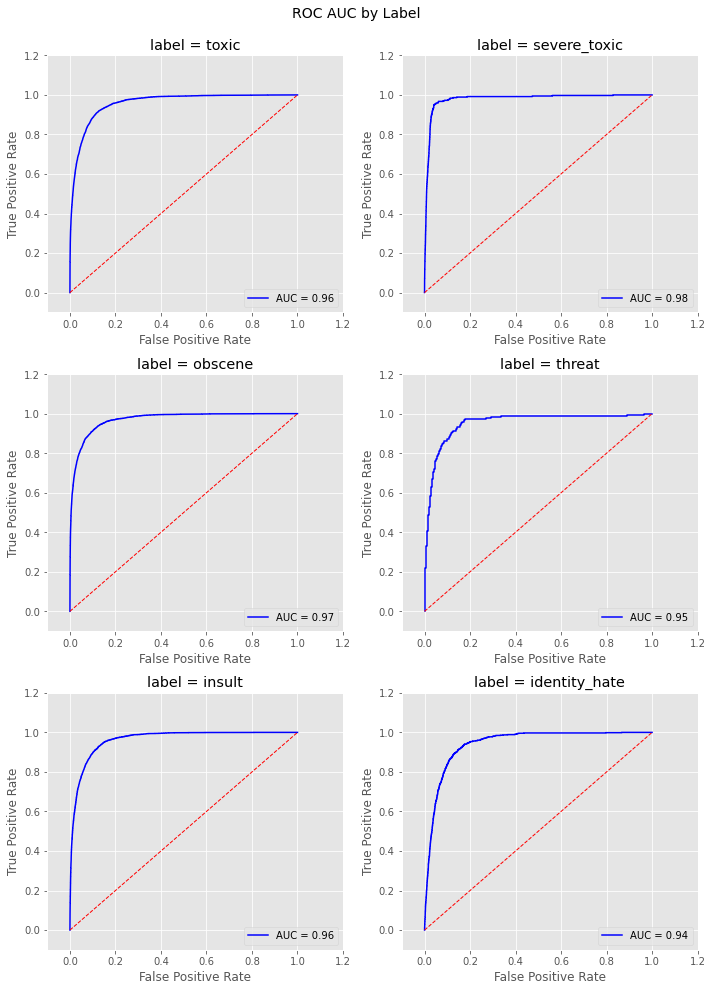

In [162]:
plot_roc_auc_grid(y_test, all_predictions_ml_textstat)

In [163]:
print(round(all_roc_auc_scores_ml_textstat['ROC AUC'].mean(), 4))

0.9606


## Classic ML (w/ Vectorized Text) + DL + Classic ML (w/ Text Statistics):  Pseudo-ensemble

### Generate the Test Predictions

In [164]:
pseudo_ensemble_predictions = [None] * num_labels

for i in range(num_labels):
    these_ml_predictions = all_predictions_ml[i][:, 1]
    these_dl_predictions = all_predictions_dl[i]
    these_dl_predictions_textstat = all_predictions_dl[i]
    
    pseudo_ensemble_predictions[i] = (these_ml_predictions + these_dl_predictions + these_dl_predictions_textstat) / 3

In [165]:
all_roc_auc_scores_2 = pd.DataFrame()

print('PREDICT')

for i in range(num_labels):
    print('Label ' + str(i))
    this_predict_proba = pseudo_ensemble_predictions[i] 
    
    this_roc_auc_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test.iloc[:, i], this_predict_proba), 4)]
    })
    all_roc_auc_scores_2 = pd.concat([all_roc_auc_scores_2, this_roc_auc_score], axis = 0)

PREDICT
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [166]:
all_roc_auc_scores_2.reset_index(drop = True)

,column,ROC AUC
0,toxic,0.9616
1,severe_toxic,0.9870
2,obscene,0.9750
3,threat,0.9856
4,insult,0.9684
5,identity_hate,0.9790


In [167]:
print(round(all_roc_auc_scores_2['ROC AUC'].mean(), 4))

0.9761
